![alt text](awesome_logo.png "Awesome Retirement Portfolio Projector Tool")

# My Portfolio

In [10]:
import sqlalchemy as sql
import pandas as pd
import os
import datetime
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
import hvplot.pandas
load_dotenv()
import numpy as np

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [11]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [12]:
 #Get porfolio data
connection_string = 'sqlite:///awesome_app.db'
engine = sql.create_engine(connection_string, echo=False)

sql = """
  SELECT *
  FROM portfolio
"""

portfolio_df = pd.read_sql_query(sql, engine)


In [13]:
#CHANGE IN INITIAL POSITION
new_quantities=pd.DataFrame({'quantity':[10,20,500,1000]})
portfolio_df.update(new_quantities)
portfolio_df

,symbol,quantity,type
0,GOOG,10.0,Equity
1,CMG,20.0,Equity
2,IBM,500.0,Equity
3,XLB,1000.0,Equity


In [14]:
print('My risk level is...')

My risk level is...


In [15]:
# Set the tickers
tickers = portfolio_df["symbol"]
# Set timeframe to one day ('1D') for the Alpaca API
timeframe = "1D"
# Set the number of years of data to fetch
num_years = 30

batch_size = 1000
num_days_data_needed = num_years * 365
first_date = datetime.datetime.now()
last_date = first_date - datetime.timedelta(days=num_days_data_needed)

def format_date_iso(date):
    return pd.Timestamp(date, tz="America/New_York").isoformat()

all_results_df = pd.DataFrame()
next_batch_date = first_date

while num_days_data_needed > 0:
    end_date = str(next_batch_date).split()[0]
    
    next_batch_date -= datetime.timedelta(days=batch_size)
    if next_batch_date < last_date:
        next_batch_date = last_date

    start_date = str(next_batch_date).split()[0]
    
    results_batch_df = alpaca.get_barset(
        tickers,
        timeframe,
        start = format_date_iso(start_date),
        end = format_date_iso(end_date),
        limit = batch_size
    ).df

    all_results_df = pd.concat([all_results_df, results_batch_df])
    num_days_data_needed -= batch_size
    
all_results_df.sort_index(inplace=True)

#Display data
# all_results_df

last_price = []
for t in portfolio_df['symbol']:
    print(t)
print(all_results_df[t]['close'][-1])
last_price.append(all_results_df[t]['close'][-1])
portfolio_df['price'] = all_results_df[t]['close'][-1]

portfolio_df['price'] = last_price
portfolio_df['total'] = portfolio_df['price'] * portfolio_df['quantity']
display(portfolio_df)
print(f"Total portfolio valus is {portfolio_df['total'].sum()}")


GOOG
CMG
IBM
XLB
84.56


ValueError: Length of values (1) does not match length of index (4)

In [ ]:
all_close_df = all_results_df.xs('close', axis=1, level=1, drop_level=False)
all_close_df.plot(figsize=[20, 10])

Risk Analysis

In [ ]:
portfolio_daily_returns = all_close_df.pct_change().dropna()
portfolio_daily_returns.head()

In [16]:
portfolio_daily_returns= all_close_df.pct_change().mean()
portfolio_daily_returns

NameError: name 'all_close_df' is not defined

In [ ]:
portfolio_daily_returns.pie()

In [ ]:
#ploting portfolio daily returns for visualizing
portfolio_daily_returns.plot(figsize=(20,10),title = 'Portfolio Daily Returns')

In [7]:
portfolio_cumulative_returns = (1+portfolio_daily_returns).cumprod()-1
portfolio_cumulative_price.head()

NameError: name 'portfolio_daily_returns' is not defined

In [8]:
#cumulative returns plot 
portfolio_cumulative_returns.plot(figsize=(20,10),title = 'portfolio cumulative Returns')

NameError: name 'portfolio_cumulative_returns' is not defined

<AxesSubplot:ylabel='Density'>

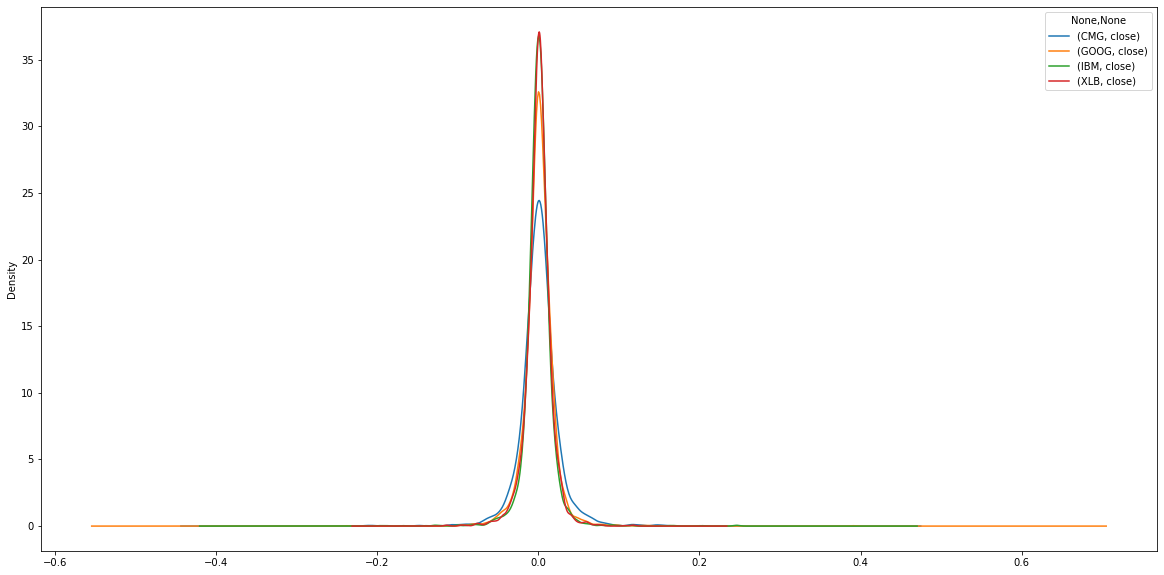

In [64]:
# Visualize the distribution of percent change in closing price for the three stocks using a density plot
portfolio_daily_returns.plot.density(figsize=(20,10))

In [65]:
# There are 252 trading days in a year
#calculating annaualized yearly returns
year_trading_days = 252
average_annual_return = portfolio_daily_returns.mean() * year_trading_days
average_annual_return

CMG   close    0.264415
GOOG  close    0.203442
IBM   close    0.066499
XLB   close    0.086033
dtype: float64

In [66]:
#Annualized stardard deviation
annualized_standard_deviation = portfolio_daily_returns.std() * (year_trading_days ** (1 / 2))
annualized_standard_deviation

CMG   close    0.392730
GOOG  close    0.318859
IBM   close    0.295182
XLB   close    0.253379
dtype: float64

In [74]:
df_bar = pd.DataFrame(
    {
        "ticker": ["CMG", "GOOG", "IBM", "XLB"],
        "daily_return": (4.50, 10, 33.0, 55.25),
    }
)
    

<AxesSubplot:xlabel='Ticker', ylabel='Daily Return'>

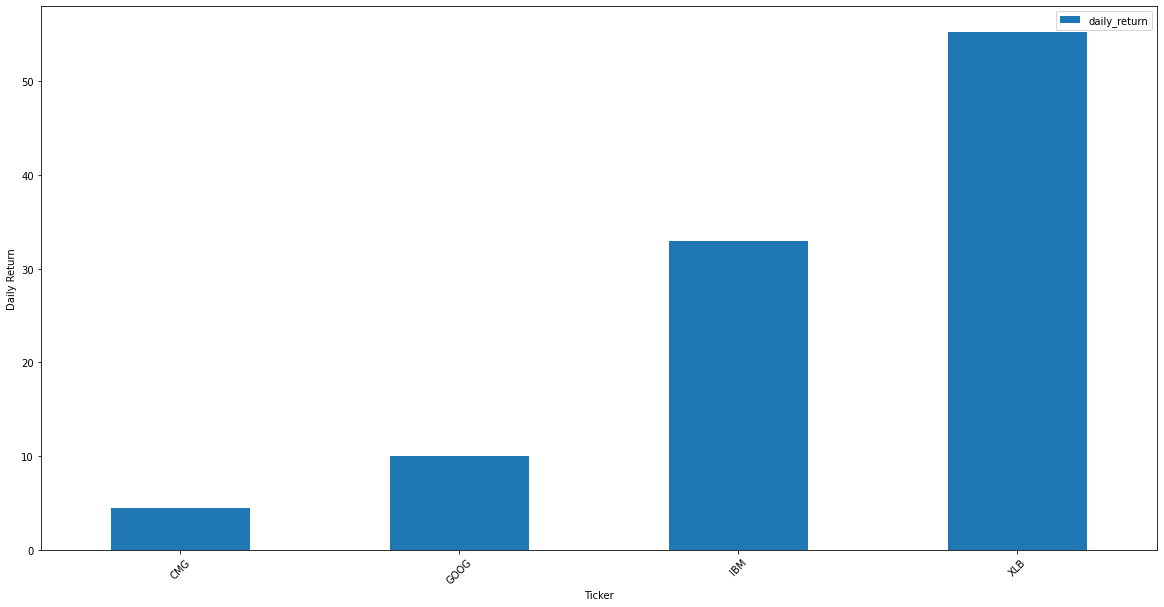

In [78]:
df_bar.plot.bar(
    x="ticker", 
    y="daily_return", 
    xlabel="Ticker", 
    ylabel="Daily Return", 
    rot=45,
    figsize=(20,10)
)

In [77]:
sharpe_ratios = average_annual_return / annualized_standard_deviation

sharpe_ratios

CMG   close    0.673273
GOOG  close    0.638032
IBM   close    0.225280
XLB   close    0.339542
dtype: float64

In [70]:
print("Current portfolio expected return")
print("Current portfolio volatility")
print("Current portfolio sharpe ratio")

Current portfolio expected return
Current portfolio volatility
Current portfolio sharpe ratio


In [ ]:
portfolio_weights = np.array(portfolio_weights)
#Annual expected return by the weighted average of the historical average of daily returns of each security, multiplied by 252
expected_annual_return = np.sum(portfolio_daily_returns.mean() * portfolio_weights) * 252
# Annual Portfolio Variance = w.T * Covariance * w    (where "*" represents here the matrix multiplication) OBS: Var_annual = Var_daily * 252
# np.dot function does a matrix multiplication. Another alternative is np.matmul
portfolio_variance = np.dot( portfolio_weights.T,   np.dot(   portfolio_daily_returns.cov() * 252, portfolio_weights   ))
portfolio_volatility = np.sqrt(portfolio_variance)
#Sharpe Ratio (annual) (Assumed risk_free_rate=0)
risk_free_rate_annualized=0
sharpe_ratio = (expected_annual_return - risk_free_rate_annualized)/portfolio_volatility

---

# My Optimized Portfolio

In [8]:
print("Optimized portfolio expected return")
print("Optimized portfolio volatility")
print("Optimized portfolio sharpe ratio")

Optimized portfolio expected return
Optimized portfolio volatility
Optimized portfolio sharpe ratio
